# Graph Pipeline Notebook

This notebook demonstrates an end-to-end pipeline for processing satellite data. It performs the following steps:

1. **Import libraries** and set up the environment.
2. **Search for and load** the satellite netCDF files.
3. **Extract data on a GPU** using CuPy and parallel processing.
4. **Clip, bin, and plot** the rasterized chlorophyll‑a data.

Below, the code cells document each step in detail.

### Library Imports

The following cell imports essential libraries required for file handling, numerical operations, and plotting.

In [13]:
# Import essential libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from l2_pipeline import L2DatasetLoader  # Custom loader for satellite datasets

### Searching for Data Files

This cell specifies the data directory and recursively searches for netCDF files containing satellite data.

In [14]:
# Specify the data directory and search recursively for netCDF files
data_dir = r"E:\satdata"
nc_files = glob.glob(os.path.join(data_dir, '**', '*.nc'), recursive=True)
print(f"Found {len(nc_files)} files.")

Found 204 files.


### Loading Datasets

Using the custom L2DatasetLoader, this cell loads multiple datasets from the discovered netCDF files.

In [15]:
# Load datasets using a custom L2DatasetLoader
loader = L2DatasetLoader(variable='chlor_a')
datasets = loader.load_multiple(nc_files)
print(f"Loaded {len(datasets)} datasets.")

204

### GPU Data Extraction

This cell leverages the GPU with CuPy and parallel processing (via ThreadPoolExecutor) to extract and filter the satellite data.

In [16]:
# Import modules for GPU processing and parallel execution
import cupy as cp
from concurrent.futures import ThreadPoolExecutor

# === Settings ===
datasets_subset = datasets  # Process all available datasets

# === GPU Data Extraction Function ===
def extract_data_gpu(ds):
    # Convert variables to CuPy arrays for GPU acceleration
    var = cp.asarray(ds['chlor_a'].values).flatten()
    lat = cp.asarray(ds['lat'].values).flatten()
    lon = cp.asarray(ds['lon'].values).flatten()

    # Mask NaN values on the GPU
    mask = ~cp.isnan(var) & ~cp.isnan(lat) & ~cp.isnan(lon)

    # Return the filtered data as NumPy arrays for plotting
    return (
        cp.asnumpy(lon[mask]),
        cp.asnumpy(lat[mask]),
        cp.asnumpy(var[mask])
    )

# === Run GPU extraction in parallel ===
with ThreadPoolExecutor() as executor:
    results = list(executor.map(extract_data_gpu, datasets_subset))

# === Concatenate all GPU-processed results ===
all_lon = np.concatenate([r[0] for r in results])
all_lat = np.concatenate([r[1] for r in results])
all_var = np.concatenate([r[2] for r in results])

### Binning and Plotting

The final cell computes a 2D binned mean statistic for the chlorophyll-a data, then clips the data to a bounding box and plots it on a map.

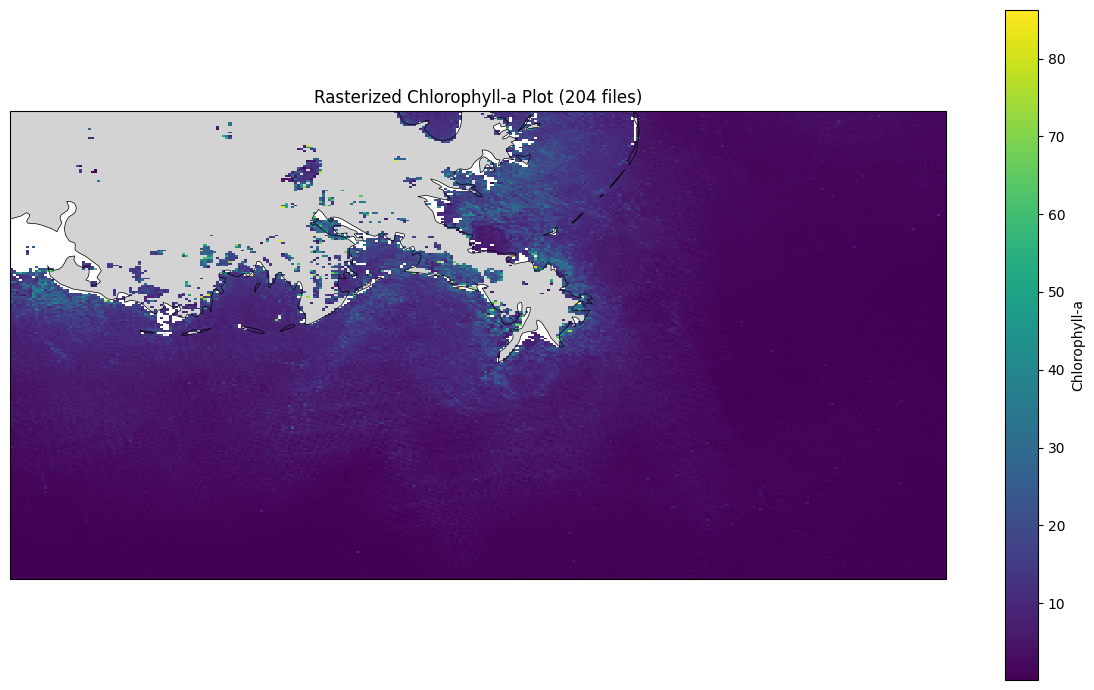

In [19]:
from scipy.stats import binned_statistic_2d

# === Define Bounding Box for Chlorophyll-a Data ===
lon_min, lon_max = -91.5, -87.5
lat_min, lat_max = 28.0, 30.0

# === Clip data to the bounding box ===
mask = (
    (all_lon >= lon_min) & (all_lon <= lon_max) &
    (all_lat >= lat_min) & (all_lat <= lat_max)
)
clipped_lon = all_lon[mask]
clipped_lat = all_lat[mask]
clipped_var = all_var[mask]

# === Define binning parameters ===
lat_bins, lon_bins = 250, 300

# === Compute 2D binned mean statistic over the clipped data ===
stat, lat_edges, lon_edges, _ = binned_statistic_2d(
    clipped_lat, clipped_lon, clipped_var, statistic='mean', bins=[lat_bins, lon_bins],
    range=[[lat_min, lat_max], [lon_min, lon_max]]
)

# === Generate meshgrid for pcolormesh using bin edges ===
lon_grid, lat_grid = np.meshgrid(lon_edges, lat_edges)

# === Plotting the Rasterized Chlorophyll-a Map ===
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the map extent using the bounding box
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot the raster data with a consistent color map
raster = ax.pcolormesh(
    lon_grid, lat_grid, stat,
    cmap='viridis', shading='auto',
    transform=ccrs.PlateCarree()
)

# Add coastlines and land features for context
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Display a colorbar and map title
plt.colorbar(raster, label='Chlorophyll-a')
plt.title(f"Rasterized Chlorophyll-a Plot ({len(datasets_subset)} files)")
plt.tight_layout()
plt.show()